In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Metropolisovým algoritmem simulujte soustavu 500 atomů argonu plynu při teplotě 170 K a číselné hustotě N/V = 0.14287 mol/dm3. 

### Argon modelujte mezičásticovým potenciálem Lannard-Jonese s parametry e = 119.8 kB, s = 0.341 nm. 

### Proveďte také plnou simulaci mikroskopických stavů ve fázovém prostoru (generujte polohy i hybnosti částic).

### Vypočtěte radiální distribuční funkci argonu za zmíněných podmínek a sestrojte její graf.

In [126]:
pocet_castic = 500
teplota = 170                             # [K]
hmotnost_argonu = 39.948*1.6605390666e-27 # [kg]
hustota_molarni = 0.14287 * 10**3         # N \V [mol/ m**3]

avogadrova_konst = 6.022E23
ciselna_hustota = hustota_molarni * avogadrova_konst  
objem = pocet_castic / ciselna_hustota  
strana_boxu = objem**(1/3)

boltzmanova_konstanta = 1.380649e-23      # [J*K^-1]
epsilon = 119.8 * boltzmanova_konstanta # [J/K]
sigma = 0.341E-9                        # [m]

r_cut = 15*sigma

In [127]:
def generace_poc_poloh(pocet_castic, strana_boxu):
    polohy = np.random.uniform(0, strana_boxu, (pocet_castic, 3))
    return polohy

### Generace rychlosti pomoci - Ekviparticni teoriumu Max Boltzman
$ \frac{1}{2} m \vec v^2  =\frac{1}{2} m (v^2_{x} +v^2_{y} +v^2_{z}) = \frac{1}{2} k_b T $,   
    kde $\frac{1}{2} k_b T $ - prvni stupen voltosti

In [128]:
def generace_poc_rychlosti(pocet_castic, hmotnost_argonu, boltzmanova_konstanta, teplota):
    odchylka_rychlosti = np.sqrt(boltzmanova_konstanta * teplota / hmotnost_argonu)
    rychlosti = np.random.normal(0, odchylka_rychlosti, (pocet_castic, 3))
    rychlosti -= np.mean(rychlosti,axis= 0) # aby sum v = 0, system se nepochybuje
    return rychlosti

# $I$

### Vypocet vzdalenosti dvou castic metodou obrazu

$ r_{abs} = |\vec{r_{1}} - \vec{r_{2}}| = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2} $

[N,1,3] - [1, N, 3] = [N,N,3] * pro 3c= [ [[1-1][1-2][1-3]] , [2-1][2-2][2-3]... ]

maska vynecha doubly pro pary a, vzdalenosti castic s sebou, nad diag prvky

In [129]:
def vypocet_vzdalenosti(polohy, strana_boxu, r_cut):
    rozdily = polohy[:, np.newaxis, :] - polohy[np.newaxis, :, :] 
    rozdily -= np.round(rozdily / strana_boxu) * strana_boxu 
    i, j = np.triu_indices(len(polohy), k=1) # indxy unikatnich paru
    
    vektor_vzdalenosti = rozdily[i, j]  
    abs_vzdal = np.linalg.norm(vektor_vzdalenosti, axis=1) 
    
    maska = abs_vzdal < r_cut
    return abs_vzdal[maska]

In [130]:
def vypocet_vzdal_pro_1_c(polohy, idx_castice, strana_boxu, r_cut, pocet_castic ):
    rozdily = polohy - polohy[idx_castice]
    rozdily -= np.round(rozdily / strana_boxu) * strana_boxu
    abs_vzdal = np.linalg.norm(rozdily, axis=1)
    
    maska = (abs_vzdal< r_cut) & (np.arange(pocet_castic)!= idx_castice)
    return abs_vzdal[maska] 

# $II$

#### LJ potencialni energie paru

#### $ U_{r_{ij}} = 4 \epsilon \sum{[ (\frac {\sigma}{r_{abs}})^{12} - (\frac {\sigma}{r_{abs}})^{6} ]} $

#### $U_{total} = \sum_{i=1}^{N-1} \sum_{j=i+1}^{N} U_{r_{ij}}  $ 

In [131]:
def celkova_pot_en(polohy, epsilon, sigma, r_cut, strana_boxu):
    abs_vzdal = vypocet_vzdalenosti(polohy, strana_boxu, r_cut)

    if abs_vzdal.size == 0:
        return 0.0

    r6 = (sigma / abs_vzdal)**6
    r12 = r6**2
    
    pot_en_paru = 4*epsilon * (r12 - r6)
    celk_pot_e = np.sum(pot_en_paru)
      
    return celk_pot_e

In [132]:
def pot_en_okolo_1_c(polohy, epsilon, sigma, r_cut, strana_boxu, pocet_castic, idx_castice):
    abs_vzdal = vypocet_vzdal_pro_1_c(polohy, idx_castice, strana_boxu, r_cut, pocet_castic )

    if abs_vzdal.size == 0:
        return 0.0

    r6 = (sigma / abs_vzdal)**6
    r12 = r6**2
    
    pot_en_paru = 4*epsilon * (r12 - r6)
    celk_pot_e = np.sum(pot_en_paru)
      
    return celk_pot_e

### $E_{\text{kin}} = \frac{|\vec{p}|^2}{2m}$

### $E_{\text{kin, total}} = \sum_{i=1}^{N} \frac{|\vec{p}_i|^2}{2m} = \sum_{i=1}^{N} \frac{p_{x_i}^2 + p_{y_i}^2 + p_{z_i}^2}{2m} $


In [133]:
def celkova_kin_en(hybnosti, hmotnost_argonu):
    suma_hyb = np.sum(np.linalg.norm(hybnosti, axis=1)**2)
    kin_tot = suma_hyb/(2 * hmotnost_argonu)
    
    return kin_tot

# $III$

## Metropolis postup
#### 0 Spocitat predchozi energie systemu kin a pot

#### 1 Zmena polohy a hybnosti nahodne veleciny
Vektor nahodneho posunuti catice  $u_{max}$, vybirame pokus-omyl, ale pro pocatecni experiment muze byt  $u_{max} = 2\sigma$

Nova poloha $\vec{r_{z}^{i}} [\sigma]$  
### $ \vec{r_{z}^{i}} = \vec{r_{i}^{j}} + \vec{u} (- u_{max},  u_{max}) $

Nova hybnost $\vec{p_{z}^{i}}$. Pro $\nu_{max} = ?500? $ 
### $ \vec{p_{z}^{i}} = \vec{p_{i}^{j}} + \vec{\nu} (- \nu_{max},  \nu_{max}) $

meli bysme prevadet na rychlosti(Ne hybnosti) a menit je, protoze se liseji radove

In [134]:
def posunuti(stara_poloha, velikost_strany_boxu, u_max = 20*sigma): 
    nova_poloha = stara_poloha + np.random.uniform(-u_max, u_max, 3)
    return nova_poloha % velikost_strany_boxu

def zmena_hybnosti(stara_hybnost, hmotnost_argonu, nu_max = 300):
    rychlost = stara_hybnost / hmotnost_argonu
    nova_rychlost = rychlost + np.random.uniform(-nu_max, nu_max, 3) 
    nova_hybnost = hmotnost_argonu * nova_rychlost
    return nova_hybnost

####  2 Zmena $E_{kin}$ a $E_{pot}$ v celem systemu

#### $\Delta E = E_{nova} - E_{stara} \Rightarrow \Delta E \le 0 ... $ prijmame zmeny. $ \Delta E > 0:$ prijimame zmeny polohy/hybosti s pravdepodobnosti $P = e^{-\Delta E / (k_B T)} $ kterou poravnavame s nahodnym cislem r, s rovnomernym rozlozenim $r \in [0,1] $

$r<P$ prijmame zmeny (t.z P je blizko 1), $r \ge P$ odmitame

In [135]:
def pravdepodobnostni_kriterium(delta_e, boltzmanova_konstanta, teplota):
    return True if delta_e <= 0 or np.random.rand() < np.exp(-delta_e / (boltzmanova_konstanta * teplota)) else False

In [136]:
def metropolis_krok(polohy, hybnosti, epsilon, sigma, r_cut, strana_boxu, pocet_castic, boltzmanova_konstanta, teplota, hmotnost_argonu):
    idx_castice = np.random.randint(0,pocet_castic)
    
    stara_pot_en = pot_en_okolo_1_c(polohy, epsilon, sigma, r_cut, strana_boxu, pocet_castic, idx_castice)
    stara_kin_en = celkova_kin_en(hybnosti, hmotnost_argonu)
    
    nove_polohy = np.array(polohy)
    nove_hybnosti = np.array(hybnosti)
    
    nove_polohy[idx_castice] = posunuti(polohy[idx_castice], strana_boxu)
    nove_hybnosti[idx_castice] = zmena_hybnosti(hybnosti[idx_castice], hmotnost_argonu)
    
    nova_e_pot = pot_en_okolo_1_c(nove_polohy, epsilon, sigma, r_cut, strana_boxu, pocet_castic, idx_castice)
    nova_e_kin = celkova_kin_en(nove_hybnosti, hmotnost_argonu)
    
    delta_e_pot = nova_e_pot - stara_pot_en
    delta_e_kin = nova_e_kin - stara_kin_en
    
    prijmout_polohy = pravdepodobnostni_kriterium(delta_e_pot, boltzmanova_konstanta, teplota)
    prijmout_hybnosti = pravdepodobnostni_kriterium(delta_e_kin, boltzmanova_konstanta, teplota)
    
    if prijmout_polohy and prijmout_hybnosti:
        return nove_polohy, nove_hybnosti, [1,1]
    elif prijmout_hybnosti:
        return polohy, nove_hybnosti, [0,1]
    elif prijmout_polohy:
        return nove_polohy, hybnosti, [1,0]
    else:
        return polohy, hybnosti, [0,0]

# $IV$

Vypocet rdf
$n(r)$ - pocet castic ve vzdalenosti r, $\rho = \frac{N}{V}$, $V(r) $- objem sfericke slupky

$ g(r) = \frac{n(r)}{\rho V(r)}$

$V(r)= \frac{4}{3}\pi [(r+\Delta r)^3 -r^3] = 4\pi r^2 \Delta r $

In [137]:
def vyp_rdf(pocet_castic, strana_boxu, r_cut, polohy, pocet_dilku):
    hustota = pocet_castic/(strana_boxu)**3
    hranice = np.linspace(0, r_cut, pocet_dilku + 1)

    rozdily = polohy[:, np.newaxis, :] - polohy[np.newaxis, :, :]
    rozdily -= np.round(rozdily / strana_boxu) * strana_boxu
    abs_vzdal = np.linalg.norm(rozdily, axis=-1)

    i, j = np.triu_indices(len(polohy), k=1)
    abs_vzdal = abs_vzdal[i, j]

    n_castic_v_slupkach, _ = np.histogram(abs_vzdal, bins=hranice)

    V_r = (4/3) * np.pi * (hranice[1:]**3 - hranice[:-1]**3)
    g_r = n_castic_v_slupkach / (V_r * hustota) / pocet_castic 
    
    return g_r 

Pocatecni podminky

In [138]:
hybnosti = np.zeros((pocet_castic,3))
pocet_kroku_ekv = 1000
pocet_kroku_simulacnich = 100000
pocet_dilku = 100
rdf_rozlozeni = np.zeros(pocet_dilku)
prubeh_e_p = []
prubeh_e_k = []
prubeh_prijatych_zmen_pot_kin = []

polohy = generace_poc_poloh(pocet_castic, strana_boxu)
rychlosti = generace_poc_rychlosti(pocet_castic, hmotnost_argonu, boltzmanova_konstanta, teplota)
hybnosti = rychlosti*hmotnost_argonu
e_p = np.array(celkova_pot_en(polohy, epsilon, sigma, r_cut, strana_boxu))
e_k = np.array(celkova_kin_en(hybnosti, hmotnost_argonu))
prubeh_e_p.append(e_p)
prubeh_e_k.append(e_k)


for i in range(pocet_kroku_ekv):
    polohy, hybnosti, co_prijalo = metropolis_krok(polohy, hybnosti, epsilon, sigma, r_cut, strana_boxu, pocet_castic, boltzmanova_konstanta, teplota, hmotnost_argonu)
    
    e_p = np.array(celkova_pot_en(polohy, epsilon, sigma, r_cut, strana_boxu))
    e_k = np.array(celkova_kin_en(hybnosti, hmotnost_argonu))
    prubeh_e_p.append(e_p)
    prubeh_e_k.append(e_k)   


for i in range(pocet_kroku_simulacnich):
    polohy, hybnosti, co_prijalo = metropolis_krok(polohy, hybnosti, epsilon, sigma, r_cut, strana_boxu, pocet_castic, boltzmanova_konstanta, teplota, hmotnost_argonu)
    prubeh_prijatych_zmen_pot_kin.append(co_prijalo)
    
    # if i %10 ==0:
    e_p = np.array(celkova_pot_en(polohy, epsilon, sigma, r_cut, strana_boxu))
    e_k = np.array(celkova_kin_en(hybnosti, hmotnost_argonu))
    prubeh_e_p.append(e_p)
    prubeh_e_k.append(e_k)            
    if i%10 ==0:
        g_r = vyp_rdf(pocet_castic, strana_boxu, r_cut,polohy, pocet_dilku)
        rdf_rozlozeni += g_r


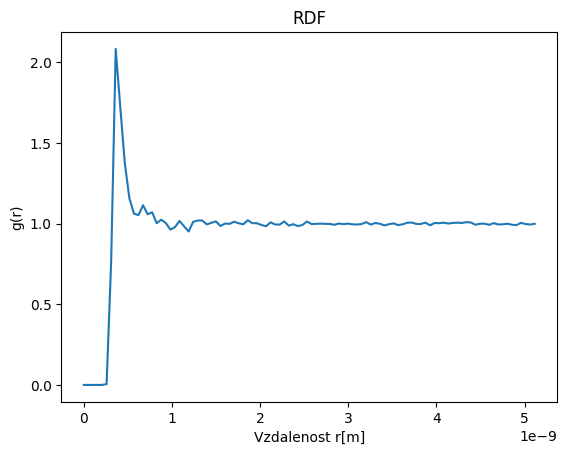

In [152]:
hranice = np.linspace(0, r_cut, pocet_dilku)
rdf_skalovani = rdf_rozlozeni / (pocet_kroku_simulacnich // 20)
plt.plot(hranice, rdf_skalovani)
plt.xlabel("Vzdalenost r[m]")
plt.ylabel("g(r)")
plt.title("RDF")
plt.show()

## Energie zobrazovani

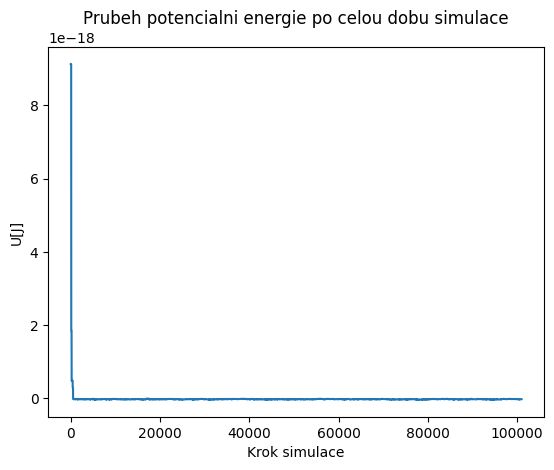

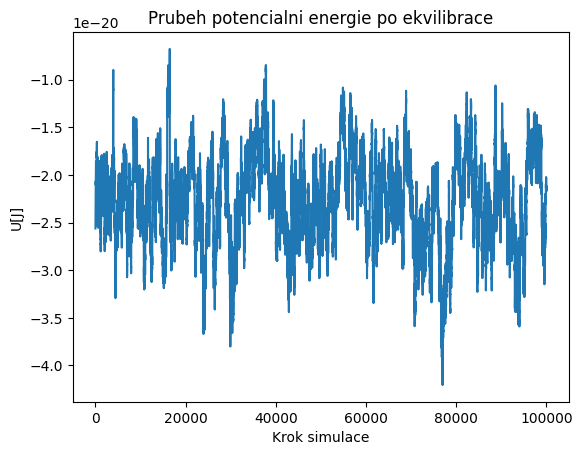

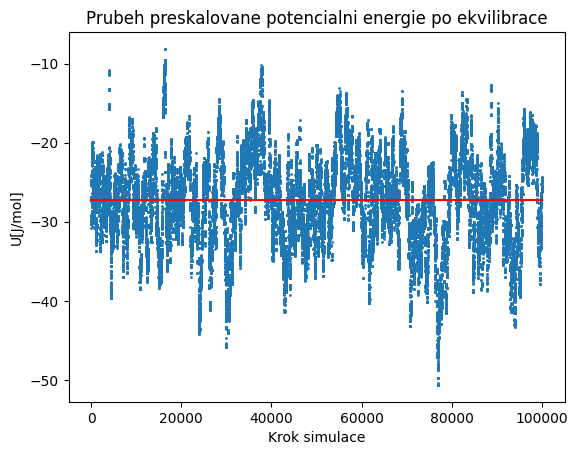

In [140]:
plt.plot(prubeh_e_p)
plt.xlabel("Krok simulace")
plt.ylabel("U[J]")
plt.title("Prubeh potencialni energie po celou dobu simulace")
plt.show()


plt.plot(prubeh_e_p[pocet_kroku_ekv:])
plt.xlabel("Krok simulace")
plt.ylabel("U[J]")
plt.title("Prubeh potencialni energie po ekvilibrace")
plt.show()

peskalovana_e_p = np.array(prubeh_e_p[pocet_kroku_ekv+1:]) / pocet_castic * avogadrova_konst
x = np.linspace(0, pocet_kroku_simulacnich, pocet_kroku_simulacnich)
prumer = np.sum(peskalovana_e_p) / len(peskalovana_e_p)
x1,y1 = [0, pocet_kroku_simulacnich], [prumer, prumer]
plt.scatter(x,peskalovana_e_p, s=1)
plt.plot(x1,y1, c = 'r')
plt.xlabel("Krok simulace")
plt.ylabel("U[J/mol]")
plt.title("Prubeh preskalovane potencialni energie po ekvilibrace")
plt.show()

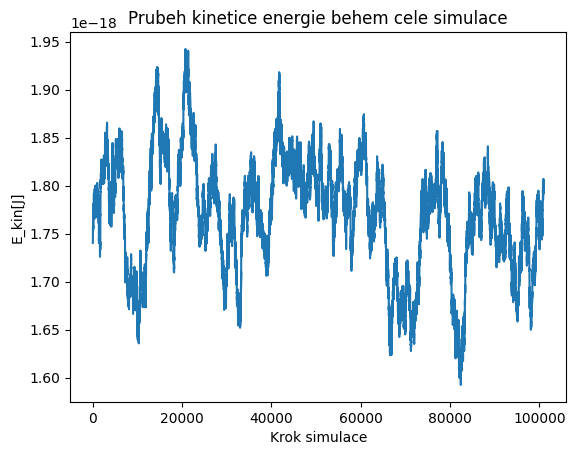

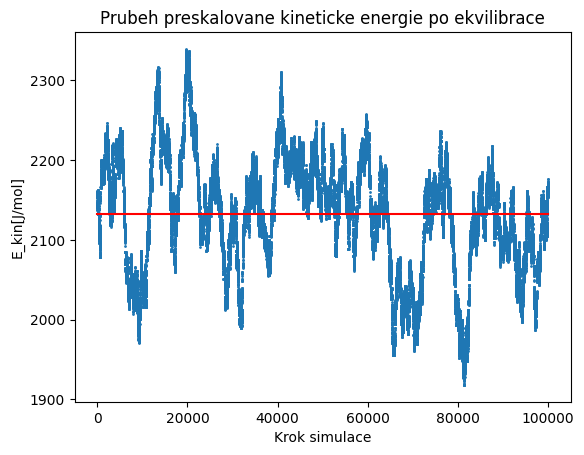

In [141]:
plt.plot(prubeh_e_k)
plt.xlabel("Krok simulace")
plt.ylabel("E_kin[J]")
plt.title("Prubeh kinetice energie behem cele simulace")
plt.show()

peskalovana_e_k = np.array(prubeh_e_k[pocet_kroku_ekv+1:]) / pocet_castic * avogadrova_konst
x = np.linspace(0, pocet_kroku_simulacnich, pocet_kroku_simulacnich)
prumer = np.sum(peskalovana_e_k) / len(peskalovana_e_k)
x1,y1 = [0, pocet_kroku_simulacnich], [prumer, prumer]
plt.scatter(x,peskalovana_e_k, s=1)
plt.plot(x1,y1, c = 'r')
plt.xlabel("Krok simulace")
plt.ylabel("E_kin[J/mol]")
plt.title("Prubeh preskalovane kineticke energie po ekvilibrace")
plt.show()

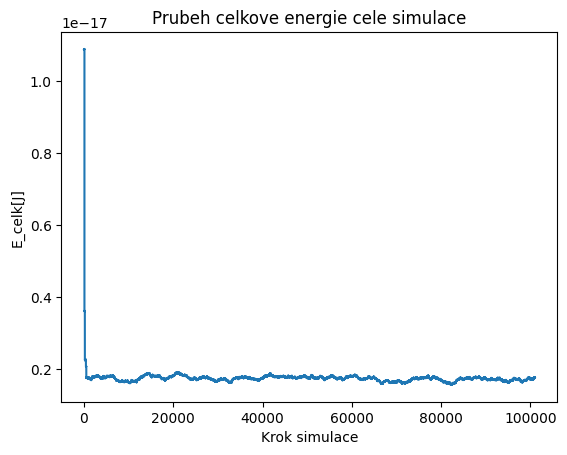

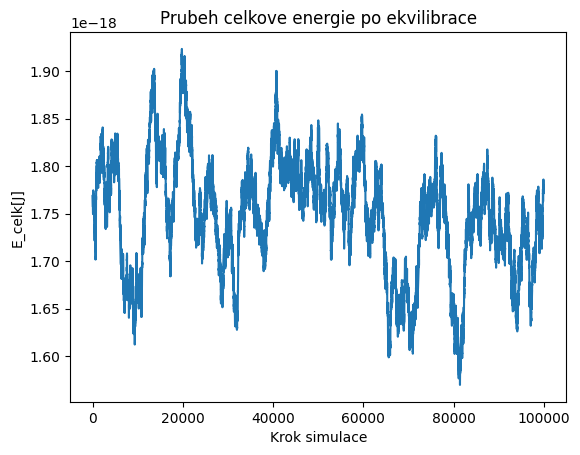

Text(0.5, 1.0, 'Prubeh preskalovane celkove energie po ekvilibrace')

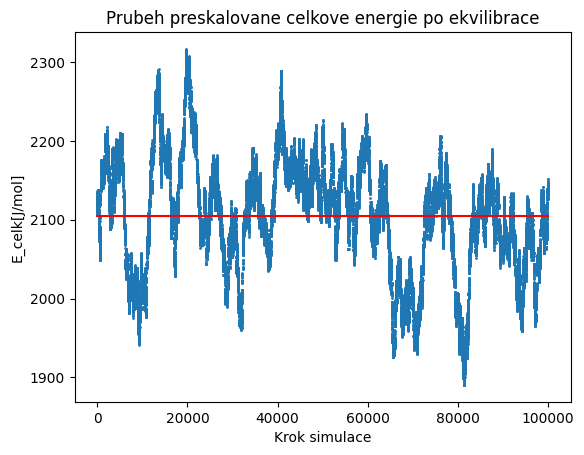

In [142]:
e_tot = np.array(prubeh_e_k) + np.array(prubeh_e_p)
plt.plot(e_tot)
plt.xlabel("Krok simulace")
plt.ylabel("E_celk[J]")
plt.title("Prubeh celkove energie cele simulace")
plt.show()

plt.plot(e_tot[pocet_kroku_ekv:])
plt.xlabel("Krok simulace")
plt.ylabel("E_celk[J]")
plt.title("Prubeh celkove energie po ekvilibrace")
plt.show()

preskalovana_c_en = e_tot[pocet_kroku_ekv+1:] / pocet_castic * avogadrova_konst
x = np.linspace(0, pocet_kroku_simulacnich, pocet_kroku_simulacnich)
prumer = np.sum(preskalovana_c_en) / len(preskalovana_c_en)
x1,y1 = [0, pocet_kroku_simulacnich], [prumer, prumer]
plt.scatter(x,preskalovana_c_en, s=1)
plt.plot(x1,y1, c = 'r')
plt.xlabel("Krok simulace")
plt.ylabel("E_celk[J/mol]")
plt.title("Prubeh preskalovane celkove energie po ekvilibrace")

In [143]:
a = np.array(prubeh_prijatych_zmen_pot_kin)
pocet_prij_zmen_c = np.sum(a, axis = 0)
procent_prijmuti = pocet_prij_zmen_c/ len(prubeh_prijatych_zmen_pot_kin)
print(f"Zmena polohy byli prijata s pravdepodobnosti {procent_prijmuti[0]*100}%")
print(f"Zmena rychlosti byla prijata s pravdepodobnosti {procent_prijmuti[1]*100}%")

Zmena polohy byli prijata s pravdepodobnosti 95.804%
Zmena rychlosti byla prijata s pravdepodobnosti 45.438%


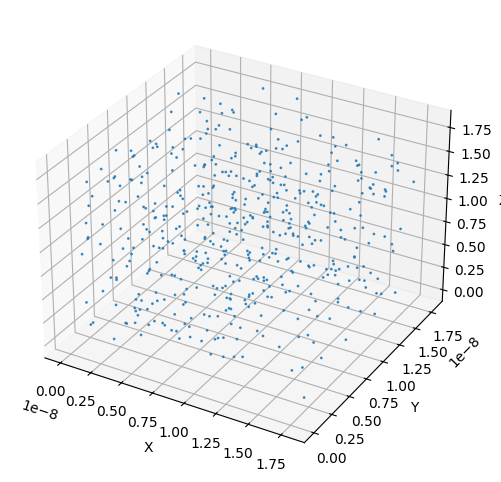

In [144]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(polohy[:, 0], polohy[:, 1], polohy[:, 2], s=1, alpha=0.8)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()